# **SKENARIO UJI COBA 3**

Klasifikasi citra USG payudara dengan arsitektur **ResNet152v2** dengan jumlah data yang diresampling, jumlah epoch sebanyak 30.

## **Persiapan Data**

Mengimpor Library dan Module yang dibutuhkan

In [1]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from google.colab import drive

Menghubungkan Google Colab dengan Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Mengakses dataset dari Google Drive

In [3]:
base_dir = '/content/drive/MyDrive/Dataset_Skripsi/Balance_Breast_Ultrasound/data'

#Menentukan direktori data training
train_dir = os.path.join(base_dir, 'train')

train_benign = train_dir+'/benign'
train_malignant = train_dir+'/malignant'
train_normal = train_dir+'/normal'

#Menentukan direktori data testing
test_dir = os.path.join(base_dir, 'test')

test_benign = test_dir+'/benign'
test_malignant =test_dir+'/malignant'
test_normal = test_dir+'/normal'

#Menghitung total data train
print('total citra train:', len(os.listdir(train_benign))+
                            len(os.listdir(train_malignant))+
                            len(os.listdir(train_normal))
                            )
#Menghitung total data test
print('total citra test:', len(os.listdir(test_benign))+
                           len(os.listdir(test_malignant))+
                           len(os.listdir(test_normal)))

total citra train: 443
total citra test: 50


## **Pemrosesan Data**

### **Resize Citra**

Mengatur ukuran citra dan batch_size

In [44]:
image_height = image_width = 224
batch_size = 16

Melakukan resize citra menjadi 224x224

In [45]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(image_height, image_width)
  )

Found 443 files belonging to 3 classes.


Melihat daftar kelas pada dataset

In [46]:
class_names = data_train.class_names
print(class_names)

['benign', 'malignant', 'normal']


Visualisasi citra pada dataset

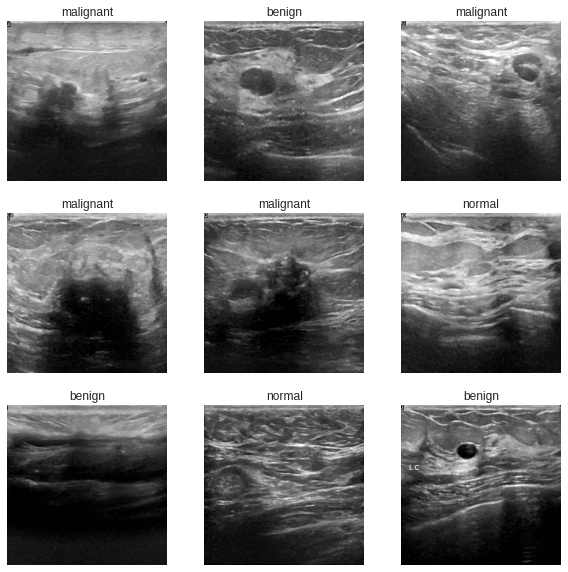

In [47]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
data_test = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(image_height, image_width)
  )

Found 50 files belonging to 3 classes.


In [49]:
class_names = data_test.class_names
print(class_names)

['benign', 'malignant', 'normal']


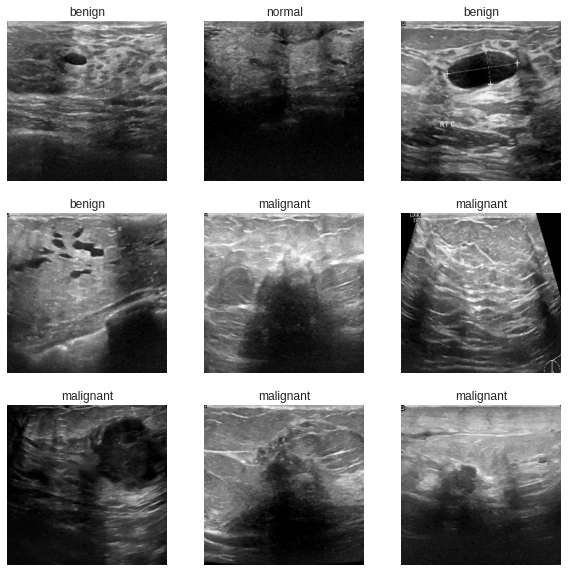

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in data_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### **Augmentasi**

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.15
                                   )
    
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.15
                                        )
test_datagen = ImageDataGenerator(rescale=1./255)

Membagi datagen untuk data train, validasi, dan test

In [52]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='training',
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='validation',
    seed = 123,
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle = False
)

Found 378 images belonging to 3 classes.
Found 65 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [53]:
from sklearn.utils import class_weight 
import numpy as np
from sklearn.utils import compute_class_weight

train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.9130434782608695, 1: 0.9130434782608695, 2: 1.2352941176470589}

## **Perancangan Arsitektur CNN**

In [54]:
from keras import regularizers
tf.keras.backend.clear_session()

from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.regularizers import L2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(image_height, image_width, 3))),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  
])
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                        

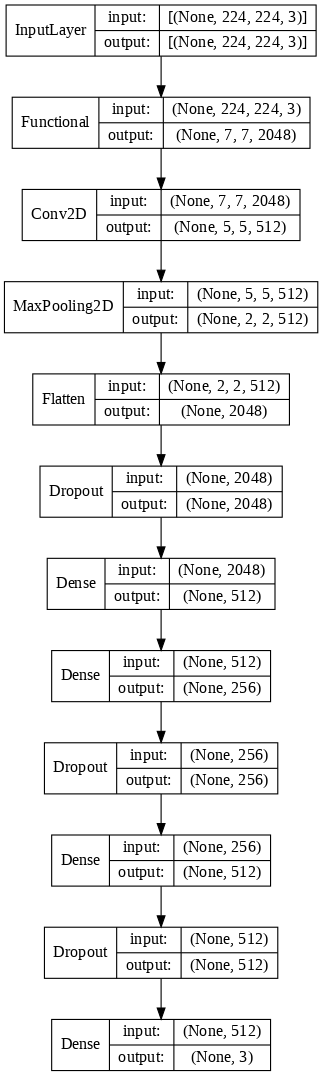

In [55]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

## **Training Model**

### Mengcompile model

In [56]:
import keras

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])

### Penggunaan Callbacks

In [57]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [58]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Train model

In [59]:
%%time
history = model.fit(train_generator, 
                    epochs=30,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr, lr_scheduler],
                    shuffle = True)

Epoch 1/30
24/24 [==============================] - 22s 590ms/step - loss: 5.2347 - accuracy: 0.3624 - specificity_at_sensitivity: 0.5384 - sensitivity_at_specificity: 0.5344 - val_loss: 3.0390 - val_accuracy: 0.3846 - val_specificity_at_sensitivity: 0.6923 - val_sensitivity_at_specificity: 0.7846 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - 10s 419ms/step - loss: 2.7973 - accuracy: 0.4735 - specificity_at_sensitivity: 0.7037 - sensitivity_at_specificity: 0.7011 - val_loss: 2.5232 - val_accuracy: 0.6615 - val_specificity_at_sensitivity: 0.9231 - val_sensitivity_at_specificity: 0.8923 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - 10s 406ms/step - loss: 2.5228 - accuracy: 0.5450 - specificity_at_sensitivity: 0.8056 - sensitivity_at_specificity: 0.7593 - val_loss: 2.0794 - val_accuracy: 0.7231 - val_specificity_at_sensitivity: 0.9538 - val_sensitivity_at_specificity: 0.9538 - lr: 0.0010
Epoch 4/30
24/24 [==============================] - 10s 430ms/st

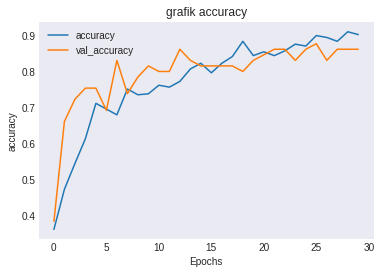

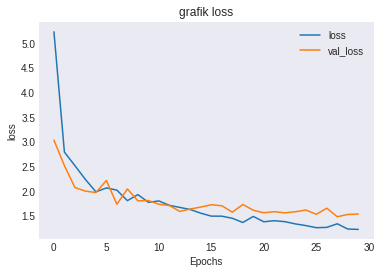

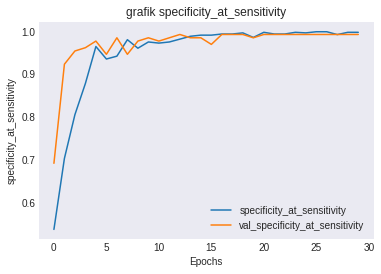

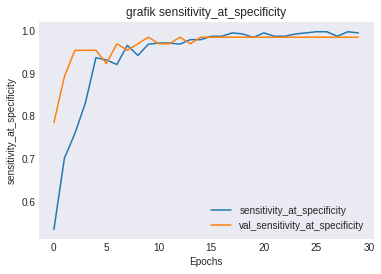

In [60]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
grafik_plot(history, "accuracy")
grafik_plot(history, "loss")
grafik_plot(history, "specificity_at_sensitivity")
grafik_plot(history, "sensitivity_at_specificity")

## **Testing Model**

In [61]:
true_labels = test_generator.classes
prob_test = model.predict(test_generator)
predictions = prob_test.argmax(axis=1)

print('Label Sebenarnya : ', true_labels)
print('Label Prediksi : ', predictions)

test_model = model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 3s 168ms/step
Label Sebenarnya :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
Label Prediksi :  [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 0 2 2 2 2 2 2 0]
4/4 [==============================] - 1s 144ms/step - loss: 1.3427 - accuracy: 0.8800 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.9800


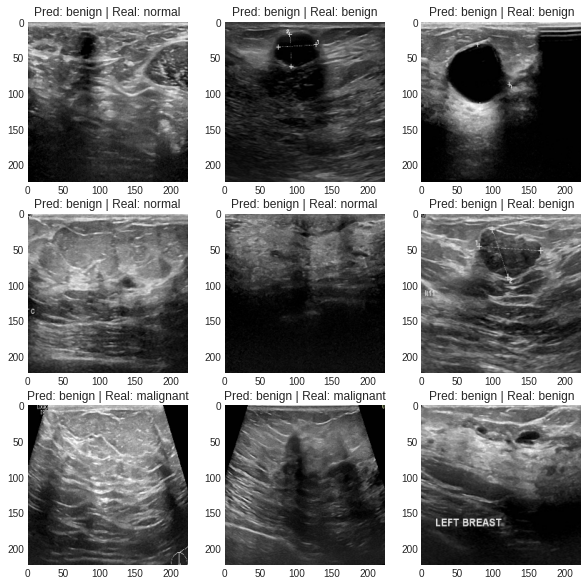

In [62]:
plt.figure(figsize=(10,10))
for images, labels in data_test.take(1):
  classifications = model(images)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [63]:
print(test_generator.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


In [65]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 224, 224, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  kelas = ['benign', 'malignant', 'normal']
  df['Kelas'] = kelas
  df = df[['Kelas', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_class = 'benign'
  elif predict_label == 1:
      predict_class = 'malignant'
  else:
      predict_class = 'normal'

  return predict_class, df

Saving malignant (3).png to malignant (3) (1).png
1/1 [==============================] - 0s 32ms/step




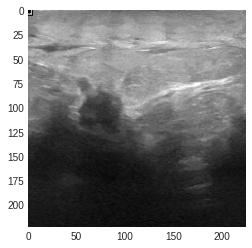


Citra dikenali sebagai malignant


       Kelas  Probability
0     benign     0.000084
1  malignant     0.999908
2     normal     0.000007




In [66]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nCitra dikenali sebagai " + label)
print('\n')
print(df)
print('\n')

## **Evaluasi Model**

Evaluasi menggunakan model.evaluate()

In [67]:
#Evaluasi loss, akurasi, specificity, sensitivity pada train data
loss, accuracy, specificity, sensitivity = model.evaluate(train_generator)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

24/24 [==============================] - 9s 365ms/step - loss: 1.1661 - accuracy: 0.9259 - specificity_at_sensitivity: 0.9987 - sensitivity_at_specificity: 0.9974
Loss train set:  1.166090488433838
Akurasi train set:  0.9259259104728699
Specificity train set:  0.9986772537231445
Sensitivity train set:  0.9973545074462891


In [68]:
#Evaluasi loss, akurasi, specificity, sensitivity pada validation data
val_loss, val_accuracy, val_specificity, val_sensitivity = model.evaluate(validation_generator)
print('Loss validation set: ', val_loss)
print('Akurasi validation set: ', val_accuracy)
print('Specificity validation set: ', val_specificity)
print('Sensitivity validation set: ', val_sensitivity)

5/5 [==============================] - 1s 149ms/step - loss: 1.5427 - accuracy: 0.8615 - specificity_at_sensitivity: 0.9923 - sensitivity_at_specificity: 0.9846
Loss validation set:  1.5426673889160156
Akurasi validation set:  0.8615384697914124
Specificity validation set:  0.9923076629638672
Sensitivity validation set:  0.9846153855323792


In [69]:
#Evaluasi loss, akurasi, specificity, sensitivity pada test data
test_loss, test_accuracy, test_specificity, test_sensitivity = model.evaluate(test_generator)
print('Loss test set: ', test_loss)
print('Akurasi test set: ', test_accuracy)
print('Specificity test set: ', test_specificity)
print('Sensitivity test set: ', test_sensitivity)

4/4 [==============================] - 1s 137ms/step - loss: 1.3427 - accuracy: 0.8800 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 0.9800
Loss test set:  1.3426836729049683
Akurasi test set:  0.8799999952316284
Specificity test set:  1.0
Sensitivity test set:  0.9800000190734863


Evaluasi menggunakan Confussion Matrix

In [70]:
prediction= model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=2)
prediction= (prediction > 0.5)
val_labels=test_generator.classes

4/4 - 1s - 684ms/epoch - 171ms/step


In [71]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0] 

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

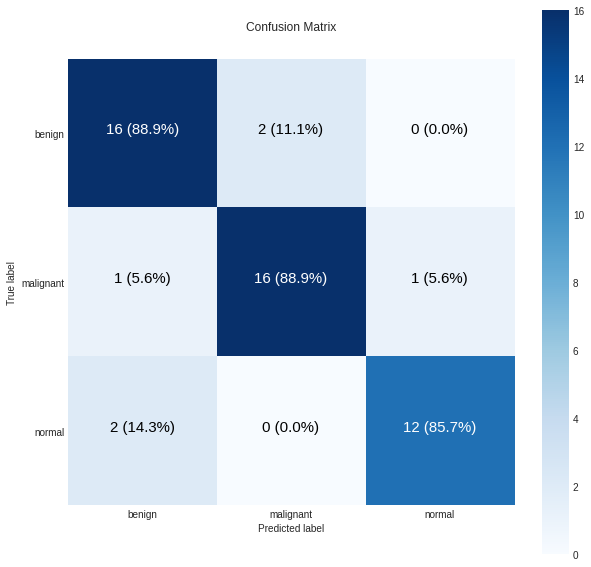

In [72]:
make_confusion_matrix(y_true=true_labels,
                      y_pred=predictions,
                      classes=test_generator.class_indices,
                      figsize=(10,10),
                      text_size=15)

In [73]:
from sklearn.metrics import classification_report

num_of_train_samples = 443
num_of_test_samples = 50
batch_size = 32

Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

4/4 [==============================] - 1s 166ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.84      0.89      0.86        18
   malignant       0.89      0.89      0.89        18
      normal       0.92      0.86      0.89        14

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



### Visualisasi AUC

4/4 [==============================] - 1s 165ms/step


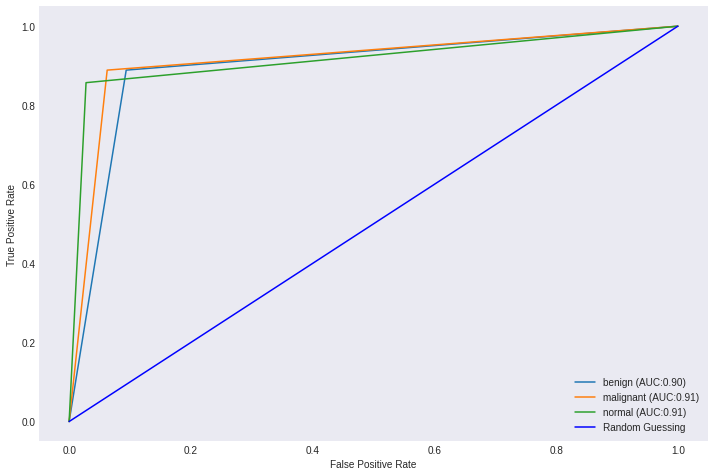

In [74]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names): 
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

test_generator.reset() 
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## **Simpan Model**

In [75]:
model.save_weights('model_simple_weights.h5')
model.save('model_skenario3.h5')

In [76]:
!cp -r '/content/model_skenario3.h5' /content/drive/MyDrive/Dataset_Skripsi/